# Visualization of the chemical space using Ersilia Compound Embeddings

In [1]:
from eosce import ErsiliaCompoundEmbeddings
import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import stylia
from sklearn.decomposition import PCA

df = pd.read_csv('../data/data_0.csv')

/Users/mduranfrigola/miniconda3/envs/osms4/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inchikeys_list = df['InchiKey'].tolist()
smiles_list = df['Smiles'].tolist()
embedder = ErsiliaCompoundEmbeddings()
X = embedder.transform(smiles_list)

In [3]:
reducer_0 = PCA(n_components=0.9)
P_0 = reducer_0.fit_transform(X)

reducer_1 = UMAP(n_components=2)
P = reducer_1.fit_transform(P_0)

In [63]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm
mw_list = [Descriptors.MolWt(Chem.MolFromSmiles(smiles)) for smiles in tqdm(smiles_list)]

In [80]:
import random
from tqdm import tqdm

example_smiles_by_phase = []
all_phases = ["data_0.csv", "data_1.csv", "data_2.csv", "data_3.csv", "data_4.csv", "data_5.csv", "data_6.csv", "data_7.csv", "data_8.csv", "data_9.csv", "data_10.csv", "data_11.csv", "data_12.csv", "data_13.csv", "eosi_s4_candidates_90.csv"]
for i in tqdm(range(len(all_phases)-1)):
    df_cur = pd.read_csv(f'../data/{all_phases[i]}')
    df_new = pd.read_csv(f'../data/{all_phases[i+1]}')
    df_diff = df_cur[~df_cur['InchiKey'].isin(df_new['InchiKey'])]
    smis = df_diff['Smiles'].tolist()
    example_smiles_by_phase += [random.sample(smis, 5)]
df_cur = pd.read_csv(f'../data/{all_phases[-1]}')
example_smiles_by_phase += [random.sample(df_cur['Smiles'].tolist(), 5)]
example_smiles_by_phase = np.array(example_smiles_by_phase)

d = {"phase": all_phases}
for i in range(example_smiles_by_phase.shape[1]):
    d[f"example_{i}"] = example_smiles_by_phase[:,i]
de = pd.DataFrame(d)
de.to_csv('../assets/example_smiles_by_phase.csv', index=False)

100%|██████████| 14/14 [00:02<00:00,  4.70it/s]


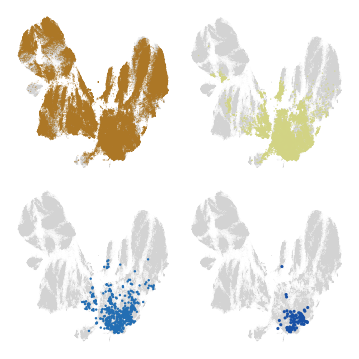

In [99]:
phase_descriptions = [
    "Generated compounds",
    "Triazolopyrazine core",
    "Physicochemical properties",
    "Synthetic feasibility",
    "Dissimilarity to existing S4",
    "Predicted active (class.)",
    "Predicted IC50 < 10uM",
    "Scaffold redundancy",
    "Filter out low activities (I)",
    "Filter out low activities (II)",
    "Remove redundancy",
    "Filter out low overall scores",
    "Filter out low MAIP scores",
    "Filter out low activity (III)",
    "Final selection"
]

15it [00:01,  9.63it/s]
/var/folders/yw/xtwk9yf95pn1k634kvjphtsh0000gn/T/ipykernel_48616/312451439.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Users/mduranfrigola/miniconda3/envs/osms4/lib/python3.11/site-packages/stylia/figure/__init__.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


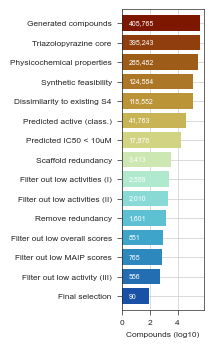

In [108]:
from stylia.colors.colors import NamedColors, ContinuousColorMap

fig, axs = stylia.create_figure(1, 1, height=stylia.TWO_COLUMNS_WIDTH*0.55, width=stylia.TWO_COLUMNS_WIDTH*0.15)
ax = axs.next()
cmap_phases = ContinuousColorMap()
cmap_phases.fit([0, len(all_phases)])
colors_phases = cmap_phases.transform(np.arange(len(all_phases)))

x = []
y = []
for i, phase in tqdm(enumerate(all_phases)):
    dp = pd.read_csv(f'../data/{phase}')
    y += [len(dp)]
    x += [i]

ax.barh(x, np.log10(y), color=colors_phases, edgecolor="none")
for i, n in zip(x,y):
    ax.text(0.5, i, "{0:,}".format(n), ha="left", va="center", color="white")
ax.set_yticks(x)
ax.set_yticklabels(phase_descriptions)
ax.set_ylim(len(all_phases)-0.3, -0.7)

stylia.label(ax=ax, title="", xlabel="Compounds (log10)", ylabel="")
plt.tight_layout()
stylia.save_figure("../assets/phases.png")

In [ ]:
named_colors = NamedColors()
cmap = ContinuousColorMap()
cmap.fit([400, 500])

def get_idxs_from_inchikeys(inchikeys, inchikeys_list):
    iks_dict = {ik: i for i, ik in enumerate(inchikeys_list)}
    idxs = []
    for inchikey in inchikeys:
        idxs.append(iks_dict[inchikey])
    return idxs

def projection_plot(ax, P, idxs, color):
    ax.scatter(P[:,0], P[:,1], s=0.01, color=named_colors.gray, edgecolor="none", alpha=0.5)
    if len(idxs) > 100000:
        s = 0.5
        alpha = 0.5
    elif len(idxs) > 10000:
        s = 1
        alpha = 0.8
    elif len(idxs) > 100:
        s = 3
        alpha = 1
    else:
        s = 5
        alpha = 1
    if idxs is not None:
        ax.scatter(P[idxs,0], P[idxs,1], s=s, color=color, edgecolors="none", alpha=alpha)
    ax.axis("off")
    stylia.label(ax=ax, title="")
    return ax

fig, axs = stylia.create_figure(2, 2, height=stylia.TWO_COLUMNS_WIDTH*0.5, width=stylia.TWO_COLUMNS_WIDTH*0.5)

# desired synthetic accessibility
ax = axs.next()

dc = pd.read_csv("../data/data_3.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, colors_phases[all_phases.index("data_3.csv")])

# predicted high activity
ax = axs.next()
dc = pd.read_csv("../data/data_6.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, colors_phases[all_phases.index("data_6.csv")])

# selection by activity of other models
ax = axs.next()
dc = pd.read_csv("../data/data_13.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, colors_phases[all_phases.index("data_13.csv")])

# final selection of 90 compounds
ax = axs.next()
dc = pd.read_csv("../data/eosi_s4_candidates_90.csv")
idxs = get_idxs_from_inchikeys(dc['InchiKey'].tolist(), inchikeys_list)
projection_plot(ax, P, idxs, colors_phases[all_phases.index("eosi_s4_candidates_90.csv")])

plt.tight_layout()
stylia.save_figure("../assets/projections_plots.png")

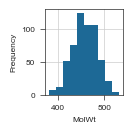

In [42]:
df = pd.read_csv('../data/data_13.csv')

fig, axs = stylia.create_figure(1,1, height=stylia.TWO_COLUMNS_WIDTH*0.18, width=stylia.TWO_COLUMNS_WIDTH*0.18)
ax = axs.next()
ax.hist(df["MolWt"], color=named_colors.blue, bins=10, edgecolor="none")
stylia.label(ax=ax, title="", xlabel="MolWt", ylabel="Frequency")
plt.tight_layout()

stylia.save_figure("../assets/molecular_weight_histogram.png")

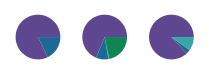

In [62]:
fig, axs = stylia.create_figure(1,3, height=stylia.TWO_COLUMNS_WIDTH*0.1, width=stylia.TWO_COLUMNS_WIDTH*0.3)

def pie_chart(ax, df, columns):
    dr = df[columns]
    R = []
    for v in dr.values:
        if np.sum(v) > 1:
            continue
        R.append(v)
    R = np.array(R)
    x = []
    for i in range(R.shape[1]):
        x.append(np.sum(R[:,i])/R.shape[0])
    x = x + [1-np.sum(x)]
    ax.pie(x, wedgeprops={"edgecolor":"none"})
    ax.axis("off")
    stylia.label(ax=ax, title="")

columns = [
    ["TriazoloPhenyl"],
    ["TriazoloHeteroarylPara", "TriazoloHeteroarylMeta", "TriazoloHeteroarylOrto"],
    ["PyrazineEther", "PyrazineAmide"],
]

for cols in columns:
    ax = axs.next()
    pie_chart(ax, df, cols)

plt.tight_layout()
stylia.save_figure("../assets/pie_charts.png")

In [31]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IsTriazoloPyrazine,556.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroaryl,556.0,0.868705,0.338027,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloPhenyl,556.0,0.821942,0.382906,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroarylPara,556.0,0.776978,0.416648,0.000000,1.000000,1.000000,1.000000,1.000000
TriazoloHeteroarylMeta,556.0,0.275180,0.447007,0.000000,0.000000,0.000000,1.000000,1.000000
TriazoloHeteroarylOrto,556.0,0.109712,0.312812,0.000000,0.000000,0.000000,0.000000,1.000000
TriazoloNaphthalene,556.0,0.001799,0.042409,0.000000,0.000000,0.000000,0.000000,1.000000
PyrazineEther,556.0,0.868705,0.338027,0.000000,1.000000,1.000000,1.000000,1.000000
PyrazineAmide,556.0,0.032374,0.177151,0.000000,0.000000,0.000000,0.000000,1.000000
MolWt,556.0,457.088567,25.817924,380.398000,440.370750,457.409000,476.463500,531.466000
